Library

In [ ]:
import torch
import sys
sys.path.append("./data")
from data.data_utils import get_dataloader

In [ ]:
print(torch.cuda.is_available())

In [ ]:
a = 0
print(a!=1)

In [ ]:
gpu_card = input("Enter the gpu card number you want to use (Enter x if wanna default):")
print(gpu_card !='x')

In [ ]:
from data.dataset import MNISTDataset, CIFARDataset
import pickle
from path import Path
import os
import sys
sys.path.append("data")
DATASET_DICT = {
    "mnist": MNISTDataset,
    "cifar": CIFARDataset,
}
dataset = "mnist"
CURRENT_DIR = Path().parent.abspath()
pickles_dir = CURRENT_DIR / "data" / dataset / "pickles"
with open(pickles_dir / str(182) + ".pkl", "rb") as f:
    client_dataset: DATASET_DICT[dataset] = pickle.load(f)

print(client_dataset)

In [ ]:
print(f"Total: {len(client_dataset.targets)}, data: {client_dataset.data[0]}, target: {client_dataset.targets[400]}")

In [ ]:
dataset_stats = {}
for i in range(200):
    with open(pickles_dir / str(i) + ".pkl", "rb") as f:
        client_dataset: DATASET_DICT[dataset] = pickle.load(f)
        if i not in dataset_stats:
            dataset_stats[i]={}
        for x in client_dataset.targets:
            if x.item() not in dataset_stats[i]:
                dataset_stats[i][x.item()] = 0
            dataset_stats[i][x.item()] += 1
print(dataset_stats)


In [ ]:
limit = 2
valid_users = []
for user in dataset_stats:
    if len(dataset_stats[user].keys()) >= limit:
        valid_users.append(user)
print(f' Total user: { len(dataset_stats.keys())},  valid_users: {len(valid_users)}')



In [ ]:
import matplotlib.pyplot as plt
plt.imshow(client_dataset.data[400].permute(1,2,0))
plt.show()

In [ ]:
import rich
from rich.console import Console
from rich.progress import track

logger = Console(record=0)
logger.log(
    "User [{:d}] [red]role: {:s}  [blue]hessian: {:b}".format(
                    199,
                    'learner', False,
                )
    )

In [ ]:
for i in track(
        range(10), "Training...", console=logger, disable=1
    ): 
    print(i)

In [ ]:
import random
users = [i for i in range(200)]
selected_learners = random.sample(users, 60)
remaining_users = [i for i in users if i not in selected_learners]
required_workers = 2*len(selected_learners) if 2*len(selected_learners)<= len(remaining_users) else len(selected_learners)
selected_workers = random.sample(remaining_users, required_workers)
assigned_wroker_per_task = int(len(selected_workers)/len(selected_learners))
print(f'{len(users)}, {selected_learners}, {len(selected_learners)}, {len(remaining_users)}, \n{remaining_users} \n {selected_workers}, \n {len(selected_workers)}, \n {assigned_wroker_per_task}')

In [ ]:
a ={}
def add(x):
    if x not in a:
        a[x]=[[5,4]]
    else: a[x].append([6,3])
add(2)
add(2)
print(a)

In [ ]:
a=[1,2,3]
b = [4,5,6]
a = a+b
import numpy as np

print(np.mean(b))

### Testing Mnist model

In [ ]:
import sys
sys.path.append("data")
from new_participant import User
from torch import nn
import torch
clients = [User(
            n_class=2,
            user_id=i,
            user_role= None,
            lr=0.001,
            alpha=0.0001,
            beta=0.0001,
            global_model=None,
            criterion=nn.CrossEntropyLoss(),
            batch_size=128,
            dataset='mnist',
            local_epochs=128,
            valset_ratio=0.2,
            logger=None,
            gpu=1,
            gpu_option=False,
        ) for i in range(200)]
activation = nn.ELU
features = 28 * 28   # number of flattened array
classes = 10 
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(features, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, classes),
    # don't need softmax here!
)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

# Load saved model
PATH = '/home/sujit_2021cs35/Github/Personalized_FL/model/mnist/'
checkpoint = torch.load(f'{PATH}model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
t_loss = checkpoint['loss']

for client in clients:
    loss, acc = client.test_other_model(model=model, show = True,)

    print(f' Testing model Trained for {epoch} epochs\n Training loss:{t_loss}\n testing model for client id: {client.id}, loss: {loss}, acc: {acc}')


### Traditional FL Training

In [1]:
import sys
sys.path.append("data")
from participant import User
from torch import nn
import torch
from fedlab.utils.serialization import SerializationTool
from fedlab.utils.aggregator import Aggregators
from copy import deepcopy

from data.data_utils import get_client_id_indices
from data.data_utils import get_dataset_stat
from utils import get_args, fix_random_seed
from model import get_model



dataset = 'mnist'

clients_4_training, clients_4_eval, client_num_in_total = get_client_id_indices(
        dataset
    )
args = get_args()
device = "cuda" if torch.cuda.is_available() else "cpu"
global_model = get_model(args.dataset, device)
client_num_in_total = 200
participants = [
        User(
            user_id=user_id,
            user_role= None,
            lr=args.lr,
            alpha=args.alpha,
            beta=args.beta,
            global_model=global_model,
            criterion=torch.nn.CrossEntropyLoss(),
            batch_size=args.batch_size,
            dataset=args.dataset,
            local_epochs=args.local_epochs,
            valset_ratio=args.valset_ratio,
            logger=logger,
            gpu=args.gpu,
            gpu_option=False,
        )
        for user_id in range(client_num_in_total)
    ]

training_stats = {'meta': {}, 'pers': {}}
for round in track(
        range(args.global_epochs), "Training...", console=logger, disable=args.log
    ):
    params_cache = []
    selected_learners = random.sample(clients_4_training, args.client_num_per_round)
    for user_id in selected_learners:
        temp_model = deepcopy(global_model)
        personalized_stats = participants[user_id].pers_params(local_model= global_model, worker_epochs= args.worker_epochs, training_stats=training_stats)
        params_cache.append([personalized_stats['model'], personalized_stats['acc_after']])
        global_model = deepcopy(temp_model)

    local_params = [x[0] for x in params_cache]
    local_acc = [x[1].cpu()+0.1 for x in params_cache]
    aggregated_model_params = Aggregators.fedavg_aggregate(local_params, local_acc)
    SerializationTool.deserialize_model(global_model, aggregated_model_params)

for client in clients_4_eval:
    loss, acc = client.test_other_model(model=model, show = True,)

    print(f' Testing model Trained for {epoch} epochs\n Training loss:{t_loss}\n testing model for client id: {client.id}, loss: {loss}, acc: {acc}')

Dataset Dir: /home/sujit_2021cs35/Github/Personalized_FL_MAML/data


usage: ipykernel_launcher.py [-h] [--lr LR] [--alpha ALPHA] [--beta BETA]
                             [--global_epochs GLOBAL_EPOCHS]
                             [--local_epochs LOCAL_EPOCHS]
                             [--worker_epochs WORKER_EPOCHS]
                             [--eval_epochs EVAL_EPOCHS]
                             [--pers_epochs PERS_EPOCHS] [--hf HF]
                             [--batch_size BATCH_SIZE]
                             [--valset_ratio VALSET_RATIO]
                             [--dataset {mnist,cifar}]
                             [--client_num_per_round CLIENT_NUM_PER_ROUND]
                             [--seed SEED] [--gpu GPU]
                             [--eval_while_training EVAL_WHILE_TRAINING]
                             [--log LOG]
ipykernel_launcher.py: error: unrecognized arguments: --ip=127.0.0.1 --stdin=9013 --control=9011 --hb=9010 --Session.signature_scheme="hmac-sha256" --Session.key=b"5374f1d1-f183-475c-90e8-7be89598b087" --shel

SystemExit: 2

/home/sujit_2021cs35/anaconda3/envs/test_39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Split Dataset and process

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class MNISTDataset(Dataset):
    def __init__(
        self,
        subset=None,
        data=None,
        targets=None,
        transform=None,
        target_transform=None,
    ) -> None:
        self.transform = transform
        self.target_transform = target_transform
        if (data is not None) and (targets is not None):
            self.data = data.unsqueeze(1)
            self.targets = targets
        elif subset is not None:
            self.data = torch.stack(
                list(
                    map(
                        lambda tup: tup[0]
                        if isinstance(tup[0], torch.Tensor)
                        else torch.tensor(tup[0]),
                        subset,
                    )
                )
            )
            self.targets = torch.stack(
                list(
                    map(
                        lambda tup: tup[1]
                        if isinstance(tup[1], torch.Tensor)
                        else torch.tensor(tup[1]),
                        subset,
                    )
                )
            )
        else:
            raise ValueError(
                "Data Format: subset: Tuple(data: Tensor / Image / np.ndarray, targets: Tensor) OR data: List[Tensor]  targets: List[Tensor]"
            )

    def __getitem__(self, index):
        data, targets = self.data[index], self.targets[index]

        if self.transform is not None:
            data = self.transform(self.data[index])

        if self.target_transform is not None:
            targets = self.target_transform(self.targets[index])

        return data, targets

    def __len__(self):
        return len(self.targets)
    

train_filename = "/home/sujit_2021cs35/Github/Personalized_FL/dataset/mnist/train.csv"
test_filename = "/home/sujit_2021cs35/Github/Personalized_FL/dataset/mnist/test.csv"

data_train = torch.load(train_filename)
data_test = torch.load(test_filename)

transform = transforms.Compose([
    transforms.ToPILImage(),        # Convert to PIL image
    transforms.Resize((28, 28)),    # Resize to MNIST image size
    transforms.ToTensor(),          # Convert to tensor
])

# Create an instance of your custom MNISTDataset
mnist_dataset = MNISTDataset(data=data, targets=labels, transform=transform)

# Create a DataLoader for batching and shuffling
batch_size = 64
data_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

# Iterate through the DataLoader
for batch in data_loader:
    images, labels = batch


import pickle

# Save the MNISTDataset instance to a pickle file
dataset = MNISTDataset(data=data, targets=labels, transform=transform)
pickle_file_path = "mnist_dataset.pkl"

with open(pickle_file_path, 'wb') as file:
    pickle.dump(dataset, file)


In [2]:
import pandas as pd

train_filename = "/home/sujit_2021cs35/Github/Personalized_FL/dataset/mnist/train.csv"
test_filename = "/home/sujit_2021cs35/Github/Personalized_FL/dataset/mnist/test.csv"

data_train =pd.read_csv(train_filename)
data_test = pd.read_csv(test_filename)

In [3]:
# print(data_train)

In [4]:
import torch
import numpy as np
import random


def normalize_array(arr):
    if len(arr) <= 1:
        return arr
    else: return arr / np.sum(arr)

train_dict = {}
def create_mnist_data_dict(data):
    data_dict = {}
    for index, row in  data.iterrows():
        if row['label'] not in data_dict:
            data_dict[row['label']] = []
        img = []
        for i in range(784):
            img.append(row[f'pixel{i}'])
        image = torch.tensor(img)
        image = torch.reshape(image, (28, 28))
        # print(image)
        # break
        data_dict[row['label']].append((image.numpy(), row['label']))
    return data_dict

train_dict = create_mnist_data_dict(data_train)    
# for label in train_dict.keys():
#     for data in train_dict[label]:
#         print(data)


### MNIST Dataset Class

In [5]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class MNISTDataset(Dataset):
    def __init__(
        self,
        subset=None,
        data=None,
        targets=None,
        transform=None,
        target_transform=None,
    ) -> None:
        self.transform = transform
        self.target_transform = target_transform
        if (data is not None) and (targets is not None):
            self.data = data
            self.targets = targets
        elif subset is not None:
            self.data = torch.stack(
                list(
                    map(
                        lambda tup: tup[0]
                        if isinstance(tup[0], torch.Tensor)
                        else torch.tensor(tup[0]),
                        subset,
                    )
                )
            )
            self.targets = torch.stack(
                list(
                    map(
                        lambda tup: tup[1]
                        if isinstance(tup[1], torch.Tensor)
                        else torch.tensor(tup[1]),
                        subset,
                    )
                )
            )
        else:
            raise ValueError(
                "Data Format: subset: Tuple(data: Tensor / Image / np.ndarray, targets: Tensor) OR data: List[Tensor]  targets: List[Tensor]"
            )

    def __getitem__(self, index):
        data, targets = self.data[index], self.targets[index]

        if self.transform is not None:
            data = self.transform(self.data[index])

        if self.target_transform is not None:
            targets = self.target_transform(self.targets[index])

        return data, targets

    def __len__(self):
        return len(self.targets)

In [6]:
import numpy as np
import os
import torch
import pickle
from data.dataset import N_MNISTDataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5),
])

def create_sub_dataset(dataset, minimum_number_of_class, total_classes, number_of_dataset, sub_dataset_size, data_type):
    created_dataset_dict = {}
    data_classes = list(range(total_classes))
    for i in range (number_of_dataset):
        sub_dataset_dict = {}
        ratios = None
        selected_classes = random.sample(data_classes, minimum_number_of_class)
        if data_type != 'iid':
            ratios = np.random.dirichlet(np.ones(len(selected_classes)))
        else:
            ratios = np.array([1/len(selected_classes) for _ in range(len(selected_classes))]) # IID Data
        class_sample_size = (ratios * sub_dataset_size).astype(int)
        for data_class, sample_size in zip(selected_classes, class_sample_size):
            sub_dataset_dict[data_class] = random.sample(range(len(dataset[data_class])), sample_size)
        created_dataset_dict[i] = sub_dataset_dict
    return created_dataset_dict
total_classes = 10
number_of_dataset = 200
sub_dataset_size = 500
data_type = 'iid'
for number_of_classes in range(1,11):
    sub_dataset_dict = create_sub_dataset(train_dict,number_of_classes,total_classes,number_of_dataset,sub_dataset_size,data_type)  #'iid' for equal sample size

    for subset, sub_dict in sub_dataset_dict.items():
        total_samples = sum(len(indices) for indices in sub_dict.values())
        print(f'Id: {subset}, Lengths: {[len(sub_dict[x]) for x in sub_dict]}, Total: {total_samples}')
        
        data = [torch.tensor(train_dict[class_][index][0], dtype=torch.uint8) for class_, indices in sub_dict.items() for index in indices]
        labels = [train_dict[class_][index][1] for class_, indices in sub_dict.items() for index in indices]
        data = np.array(data)
        
        # print(f'Length: {len(data)}, Data: {data}')
        # Create an instance of your custom MNISTDataset
        mnist_dataset = N_MNISTDataset(data=data, targets=labels, transform=transform)
        # break
        directory_path = f'/home/sujit_2021cs35/Github/Personalized_FL_MAML/build_dataset/nmnist/{data_type}/{number_of_classes}'
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)
        pickle_file_path = f"{directory_path}/{subset}.pkl"

        with open(pickle_file_path, 'wb') as file:
            pickle.dump(mnist_dataset, file)
   

Id: 0, Lengths: [500], Total: 500
Id: 1, Lengths: [500], Total: 500
Id: 2, Lengths: [500], Total: 500
Id: 3, Lengths: [500], Total: 500
Id: 4, Lengths: [500], Total: 500
Id: 5, Lengths: [500], Total: 500
Id: 6, Lengths: [500], Total: 500
Id: 7, Lengths: [500], Total: 500
Id: 8, Lengths: [500], Total: 500
Id: 9, Lengths: [500], Total: 500
Id: 10, Lengths: [500], Total: 500
Id: 11, Lengths: [500], Total: 500
Id: 12, Lengths: [500], Total: 500
Id: 13, Lengths: [500], Total: 500
Id: 14, Lengths: [500], Total: 500
Id: 15, Lengths: [500], Total: 500
Id: 16, Lengths: [500], Total: 500
Id: 17, Lengths: [500], Total: 500
Id: 18, Lengths: [500], Total: 500
Id: 19, Lengths: [500], Total: 500
Id: 20, Lengths: [500], Total: 500
Id: 21, Lengths: [500], Total: 500
Id: 22, Lengths: [500], Total: 500
Id: 23, Lengths: [500], Total: 500
Id: 24, Lengths: [500], Total: 500
Id: 25, Lengths: [500], Total: 500
Id: 26, Lengths: [500], Total: 500
Id: 27, Lengths: [500], Total: 500
Id: 28, Lengths: [500], Total:

In [7]:
directory_path = f'/home/sujit_2021cs35/Github/Personalized_FL_MAML/build_dataset/nmnist/{1}'
pickle_file_path = f"{directory_path}/{0}.pkl"

loaded_dataset = None
with open(pickle_file_path, 'rb') as file:
    loaded_dataset = pickle.load(file)
print(loaded_dataset)

In [8]:
print(f"Total: {len(loaded_dataset.targets)}, data: {loaded_dataset.data[400]}, target: {loaded_dataset.targets[400]}")

Total: 499, data: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   17 205 254 174   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  22 137
  249 253 253 246  54   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 170 253
  253 253 253 183   6   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  25 198 248 253
  253 175 157 231   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  76 201 253 253 238
   72  20 190 240   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

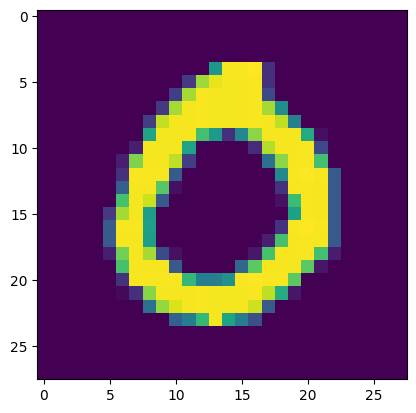

In [9]:
import matplotlib.pyplot as plt
# Specify the target size
target_size = (28, 28)  # Change this to the size you desire

# Define a transform to resize the matrix
resize_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL image
    transforms.Resize(target_size),  # Resize to the target size
    transforms.ToTensor()  # Convert back to tensor
])

# Apply the transform to the matrix
resized_matrix = resize_transform(loaded_dataset.data[0])

print(resized_matrix)
plt.imshow(resized_matrix[0])


images: tensor([[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000, -1.0000, -1.0000,

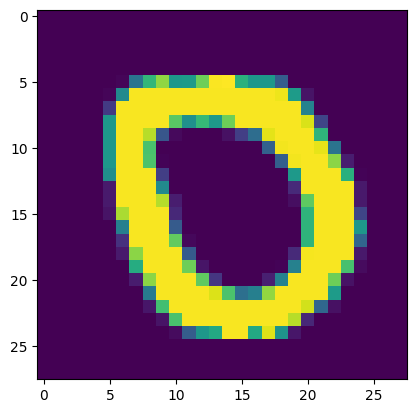

In [10]:
import matplotlib.pyplot as plt
# Create a DataLoader for batching and shuffling
batch_size = 64
data_loader = DataLoader(loaded_dataset, batch_size=batch_size, shuffle=True)

# Iterate through the DataLoader
for batch in data_loader:
    images, labels = batch
    print(f'images: {images[0][0]}, labels: {labels[0]}')
    plt.imshow(images[0][0])
    break

In [11]:
a =[ x for x in range(2,11)]
a

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [13]:

a = list(range(200))
b = random.sample(a, 160)
import numpy as np
print(f'{a}, \n {len(b)} {b} \n {[x for x in a if x not in b]}')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199], 
 160 [21, 42, 53, 144, 2, 85, 25, 194, 54, 40, 88, 27, 176, 149, 23, 135, 7, 92, 107, 72, 151, 163, 155, 59